In [3]:
import numpy as np
import pandas as pd
import pybroker
from numba import njit
from pybroker import Strategy, StrategyConfig, YFinance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from numba import njit
import pybroker
import talib
from pybroker import YFinance
pybroker.enable_caches('walkforward_strategy')

In [5]:
yfinance = YFinance()
df = yfinance.query(['AAPL', 'MSFT'], start_date='3/1/2019', end_date='3/1/2024')
df2 = yfinance.query(['AAPL', 'MSFT'], start_date='3/1/2021', end_date='3/1/2024')

Loaded cached bar data.

Loaded cached bar data.



In [7]:
sma_14 = pybroker.indicator('sma_14', lambda data: talib.SMA(data.close, timeperiod=14))
sma_14(df)

2019-03-01           NaN
2019-03-04           NaN
2019-03-05           NaN
2019-03-06           NaN
2019-03-07           NaN
                 ...    
2024-02-23    185.488571
2024-02-26    185.022858
2024-02-27    184.546429
2024-02-28    183.975715
2024-02-29    183.435000
Length: 2518, dtype: float64

In [8]:
from pybroker import IndicatorSet
indicator_set = IndicatorSet()
indicator_set.add(sma_14)
indicator_set(df)

Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


,symbol,date,sma_14
0,AAPL,2019-03-01,NaN
1,AAPL,2019-03-04,NaN
2,AAPL,2019-03-05,NaN
3,AAPL,2019-03-06,NaN
4,AAPL,2019-03-07,NaN
...,...,...,...
2513,MSFT,2024-02-23,409.178567
2514,MSFT,2024-02-26,409.313568
2515,MSFT,2024-02-27,409.455712
2516,MSFT,2024-02-28,409.003571


In [9]:
df = df.merge(indicator_set(df), how='left' ,on=['date','symbol'])
df2 = df2.merge(indicator_set(df2), how='left' ,on=['date','symbol'])

Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01



Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [10]:
df

,date,symbol,open,high,low,close,volume,adj_close,sma_14
0,2019-03-01,MSFT,112.889999,113.019997,111.669998,112.529999,23501200,106.731209,NaN
1,2019-03-04,MSFT,113.019997,113.250000,110.800003,112.260002,26608000,106.475136,NaN
2,2019-03-05,MSFT,112.250000,112.389999,111.230003,111.699997,19538300,105.943993,NaN
3,2019-03-06,MSFT,111.870003,112.660004,111.430000,111.750000,17687000,105.991409,NaN
4,2019-03-07,MSFT,111.400002,111.550003,109.870003,110.389999,25339000,104.701500,NaN
...,...,...,...,...,...,...,...,...,...
2513,2024-02-23,AAPL,185.009995,185.039993,182.229996,182.520004,45119700,182.062042,185.488571
2514,2024-02-26,AAPL,182.240005,182.759995,180.649994,181.160004,40867400,180.705460,185.022858
2515,2024-02-27,AAPL,181.100006,183.919998,179.559998,182.630005,54318900,182.171768,184.546429
2516,2024-02-28,AAPL,182.509995,183.119995,180.130005,181.419998,48953900,180.964798,183.975715


In [11]:
def cmma(bar_data, lookback):

    @njit  # Enable Numba JIT.
    def vec_cmma(values):
        # Initialize the result array.
        n = len(values)
        out = np.array([np.nan for _ in range(n)])

        # For all bars starting at lookback:
        for i in range(lookback, n):
            # Calculate the moving average for the lookback.
            ma = 0
            for j in range(i - lookback, i):
                ma += values[j]
            ma /= lookback
            # Subtract the moving average from value.
            out[i] = values[i] - ma
        return out

    # Calculate for close prices.
    return vec_cmma(bar_data.close)

cmma_20 = pybroker.indicator('cmma_20', cmma, lookback=20)

In [12]:
def train_slr(symbol, train_data, test_data):
    # Train
    # Previous day close prices.
    train_prev_close = train_data['close'].shift(1)
    # Calculate daily returns.
    train_daily_returns = (train_data['close'] - train_prev_close) / train_prev_close
    # Predict next day's return.
    train_data['pred'] = train_daily_returns.shift(-1)
    train_data = train_data.dropna()
    # Train the LinearRegession model to predict the next day's return
    # given the 20-day CMMA.
    X_train = train_data[['sma_14']]
    y_train = train_data[['pred']]
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Test
    test_prev_close = test_data['close'].shift(1)
    test_daily_returns = (test_data['close'] - test_prev_close) / test_prev_close
    test_data['pred'] = test_daily_returns.shift(-1)
    test_data = test_data.dropna()
    X_test = test_data[['sma_14']]
    y_test = test_data[['pred']]
    # Make predictions from test data.
    y_pred = model.predict(X_test)
    # Print goodness of fit.
    r2 = r2_score(y_test, np.squeeze(y_pred))
    print(symbol, f'R^2={r2}')

    # Return the trained model and columns to use as input data.
    return model, ['sma_14']

In [13]:
model_slr = pybroker.model('slr', train_slr, indicators=[sma_14])

In [14]:
config = StrategyConfig(bootstrap_sample_size=100)
strategy = Strategy(YFinance(), '3/1/2017', '3/1/2022', config)
strategy.add_execution(None, ['NVDA', 'AMD'], models=model_slr)

In [15]:
strategy.backtest(train_size=0.5)

Backtesting: 2017-03-01 00:00:00 to 2022-03-01 00:00:00

Loaded cached bar data.

Loaded cached indicator data.

Train split: 2017-03-02 00:00:00 to 2019-08-29 00:00:00
Loaded cached models.

Finished backtest: 0:00:00


TestResult(start_date=datetime.datetime(2017, 3, 1, 0, 0), end_date=datetime.datetime(2022, 3, 1, 0, 0), portfolio=Empty DataFrame
Columns: []
Index: [], positions=Empty DataFrame
Columns: []
Index: [], orders=Empty DataFrame
Columns: []
Index: [], trades=Empty DataFrame
Columns: []
Index: [], metrics=EvalMetrics(trade_count=0, initial_market_value=0, end_market_value=0, total_pnl=0, unrealized_pnl=0, total_return_pct=0, annual_return_pct=None, total_profit=0, total_loss=0, total_fees=0, max_drawdown=0, max_drawdown_pct=0, win_rate=0, loss_rate=0, winning_trades=0, losing_trades=0, avg_pnl=0, avg_return_pct=0, avg_trade_bars=0, avg_profit=0, avg_profit_pct=0, avg_winning_trade_bars=0, avg_loss=0, avg_loss_pct=0, avg_losing_trade_bars=0, largest_win=0, largest_win_pct=0, largest_win_bars=0, largest_loss=0, largest_loss_pct=0, largest_loss_bars=0, max_wins=0, max_losses=0, sharpe=0, sortino=0, calmar=None, profit_factor=0, ulcer_index=0, upi=0, equity_r2=0, std_error=0, annual_std_error=

In [16]:
def hold_long(ctx):
    if not ctx.long_pos():
        # Buy if the next bar is predicted to have a positive return:
        if ctx.preds('slr')[-1] > 0:
            ctx.buy_shares = 100
    else:
        # Sell if the next bar is predicted to have a negative return:
        if ctx.preds('slr')[-1] < 0:
            ctx.sell_shares = 100

strategy.clear_executions()
strategy.add_execution(hold_long, ['NVDA', 'AMD'], models=model_slr)

In [17]:
result = strategy.walkforward(warmup=20,timeframe='1d', windows=5, train_size=0.5,lookahead=1,calc_bootstrap=True)



Backtesting: 2017-03-01 00:00:00 to 2022-03-01 00:00:00

Loaded cached bar data.

Loaded cached indicator data.

Train split: 2017-03-08 00:00:00 to 2018-01-03 00:00:00
Loaded cached models.

Test split: 2018-01-04 00:00:00 to 2018-10-31 00:00:00


  0% (0 of 209) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (209 of 209) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2018-01-04 00:00:00 to 2018-10-31 00:00:00
Loaded cached models.

Test split: 2018-11-01 00:00:00 to 2019-09-03 00:00:00


  0% (0 of 209) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 29% (61 of 209) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (161 of 209) |################      | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (209 of 209) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2018-11-01 00:00:00 to 2019-09-03 00:00:00
Loaded cached models.

Test split: 2019-09-04 00:00:00 to 2020-07-01 00:00:00


  0% (0 of 209) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (209 of 209) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2019-09-04 00:00:00 to 2020-07-01 00:00:00
Loaded cached models.

Test split: 2020-07-02 00:00:00 to 2021-04-30 00:00:00


  0% (0 of 209) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 62% (131 of 209) |#############         | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (209 of 209) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2020-07-02 00:00:00 to 2021-04-30 00:00:00
Loaded cached models.

Test split: 2021-05-03 00:00:00 to 2022-02-28 00:00:00


  0% (0 of 209) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (209 of 209) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Calculating bootstrap metrics: sample_size=100, samples=10000...
Calculated bootstrap metrics: 0:00:04 

Finished backtest: 0:00:07


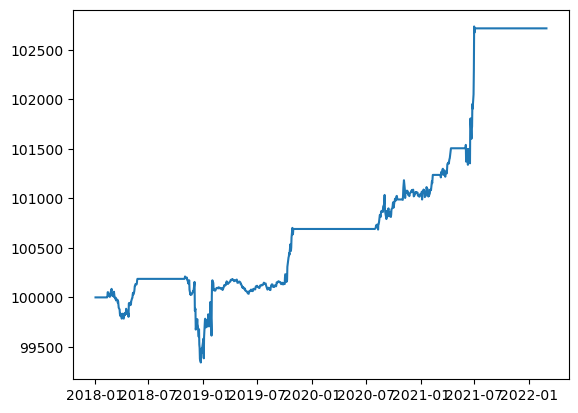

In [18]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

In [19]:
result.positions.head(10)

long_shares  short_shares  close  equity  market_value  \
symbol date                                                                 
AMD    2018-02-13          100             0  11.78  1178.0        1178.0   
       2018-02-14          100             0  12.20  1220.0        1220.0   
       2018-02-15          100             0  12.19  1219.0        1219.0   
       2018-02-16          100             0  11.82  1182.0        1182.0   
       2018-02-20          100             0  12.02  1202.0        1202.0   
       2018-02-21          100             0  11.72  1172.0        1172.0   
       2018-02-22          100             0  11.84  1184.0        1184.0   
       2018-02-23          100             0  12.07  1207.0        1207.0   
       2018-02-26          100             0  12.42  1242.0        1242.0   
       2018-02-27          100             0  12.53  1253.0        1253.0   

                   margin  unrealized_pnl  
symbol date                                
AMD    2018-02-13     0.0            11.0  
       2018-02-14     0.0            53.0  
       2018-02-15     0.0            52.0  
       2018-02-16     0.0            15.0  
       2018-02-20     0.0            35.0  
       2018-02-21     0.0             5.0  
       2018-02-22     0.0            17.0  
       2018-02-23     0.0            40.0  
       2018-02-26     0.0            75.0  
       2018-02-27     0.0            86.0

In [20]:
result.trades.iloc[:40,:]

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,AMD,2018-02-13,2018-05-25,11.67,13.54,100,187.0,16.02,187.0,71,2.63,None,-2.63,1.87
2,long,AMD,2018-12-03,2019-02-05,23.06,23.42,100,36.0,1.56,223.0,42,0.86,None,-7.03,2.08
3,long,NVDA,2018-10-31,2019-10-03,5.21,4.42,100,-79.0,-15.16,144.0,231,-0.34,None,-2.10,0.34
4,long,AMD,2019-10-03,2019-10-31,28.11,33.58,100,547.0,19.46,691.0,20,27.35,None,-0.68,5.80
5,long,NVDA,2020-08-03,2020-10-15,10.91,13.89,100,298.0,27.31,989.0,52,5.73,None,-0.19,3.82
6,long,NVDA,2020-11-02,2021-02-11,12.62,15.10,100,248.0,19.65,1237.0,69,3.59,None,-0.22,2.48
7,long,NVDA,2021-03-10,2021-04-13,12.72,15.41,100,269.0,21.15,1506.0,23,11.70,None,-0.45,2.69
8,long,AMD,2021-06-02,2021-07-02,81.63,93.74,100,1211.0,14.84,2717.0,22,55.05,None,-2.67,12.71


In [204]:
result.metrics_df

,name,value
0,trade_count,8.000000
1,initial_market_value,100000.000000
2,end_market_value,102717.000000
3,total_pnl,2717.000000
4,unrealized_pnl,0.000000
5,total_return_pct,2.717000
6,total_profit,2796.000000
7,total_loss,-79.000000
8,total_fees,0.000000
9,max_drawdown,-868.580000
